<a href="https://colab.research.google.com/github/theycomeunstuck/StudyProject_university/blob/main/smallDatasetPytorchUniversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установка необходимых модулей для работы (производится единоразово)

---




```
# Установка всех зависимостей автоматически
# try:
#     import torch # Отсутствие этой библиотеки значит и отсутствие всех других библиотек.
# except ImportError:
from google.colab import drive
drive.mount('/content/drive')

# Установка библиотек в папку Drive (чтобы не переустанавливать)
!pip3 install --target=/content/drive/MyDrive/colab_env torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install --target=/content/drive/MyDrive/colab_env matplotlib scikit-learn kaggle optuna==4.3.0 pandas==2.2.2 numpy==2.1
```




Подготовка к скачиванию датасета с kaggle



```
# from google.colab import files
# files.upload()  #Выбираем файл с ключом от каггла для скачивания датасета
```



Скачивание и распаковка датасета с kaggle



```
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Даём права на чтение
!kaggle datasets download -d johnsmith88/heart-disease-dataset
!unzip heart-disease-dataset.zip  # Распаковка (если архив)
!cp 'heart.csv' '/content/drive/MyDrive/colab_env'
```






---


Подключение необходимых библиотек

1.   pytorch — для обучения модели, анализа данных
2.   pandas — для подготовки данных к анализуу
3.   numpy — для операций с многомерными массивами
4.   matplotlib — визуализация графиков
5.   scikit-learn — для разделения графиков и метрики качества

```
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
```








---



Code

Чтение данных из файла с датасетом

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') # Подключение облачного хранилища от google, в котором хранится датасет
# Чтение данных
df = pd.read_csv('/content/drive/MyDrive/colab_env/heart.csv')


Графики.

Распределение классов target

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.0000

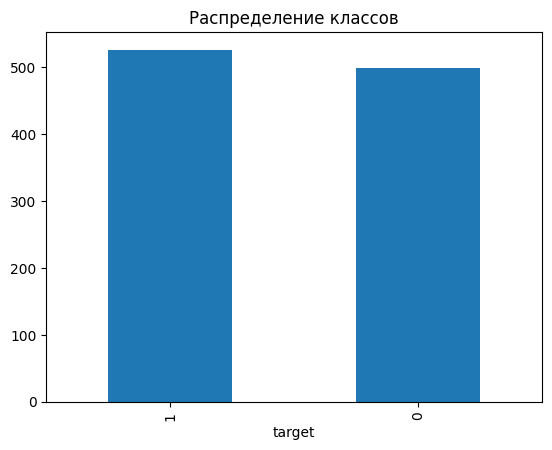

In [18]:
print(df.head())
print(df.describe())

class_counts = df['target'].value_counts()
# print(class_counts)
# Визуализация
import matplotlib.pyplot as plt
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.show()


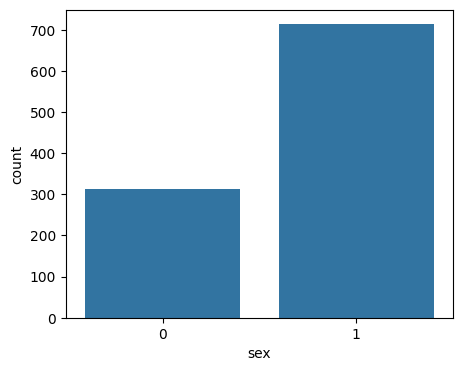

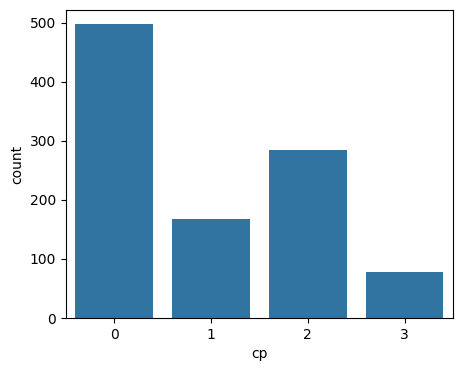

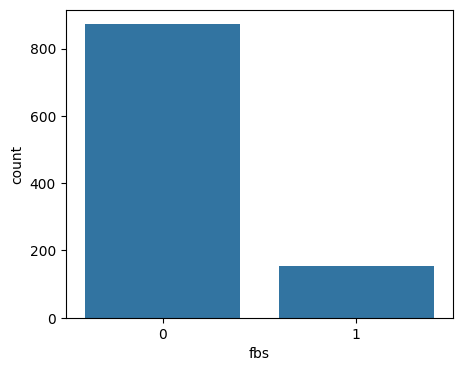

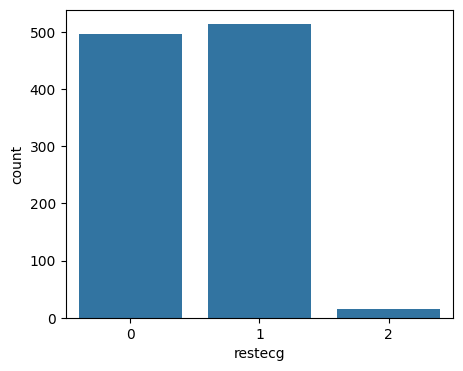

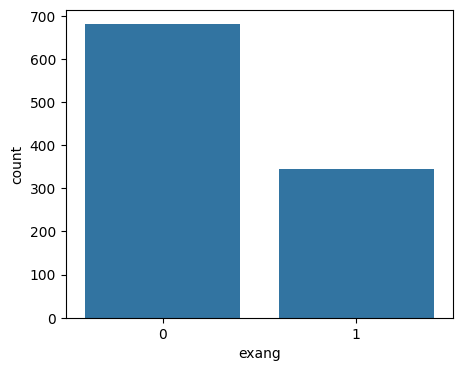

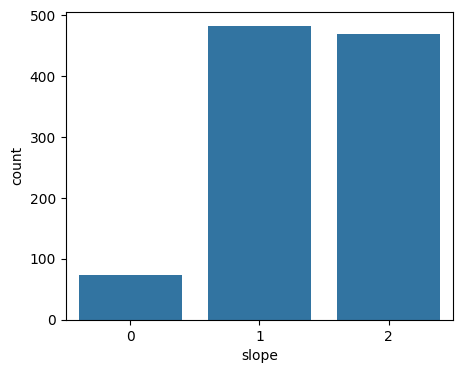

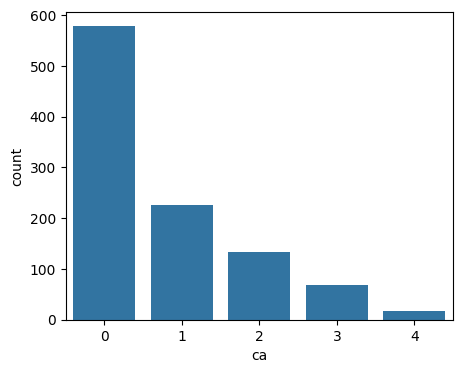

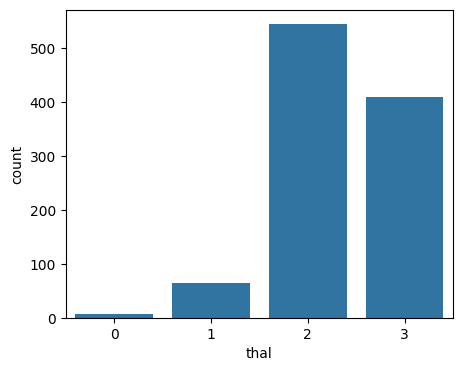

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns #Библиотека поверх matplotlib

categorial_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

for col in categorial_cols:
  plt.figure(figsize=(5,4))
  sns.countplot(x=col, data=df)


Используем pytorch для стандартизации дискретных значений



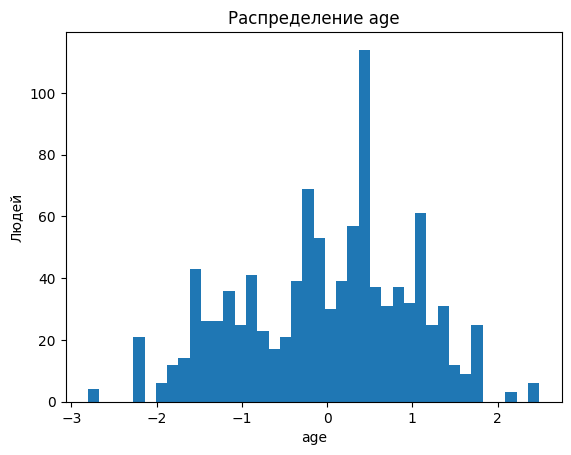

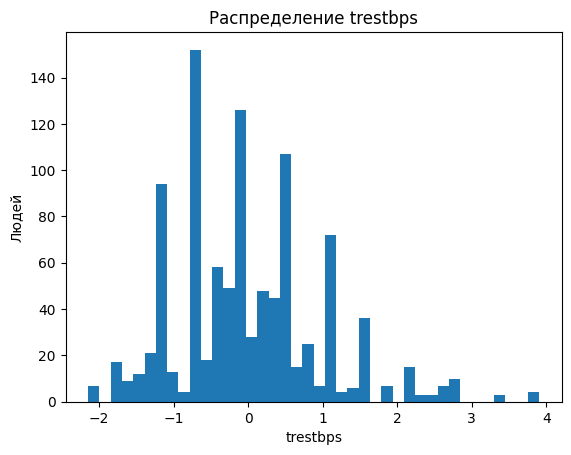

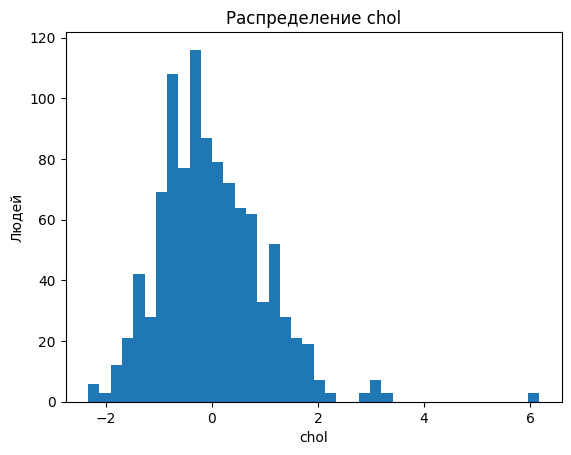

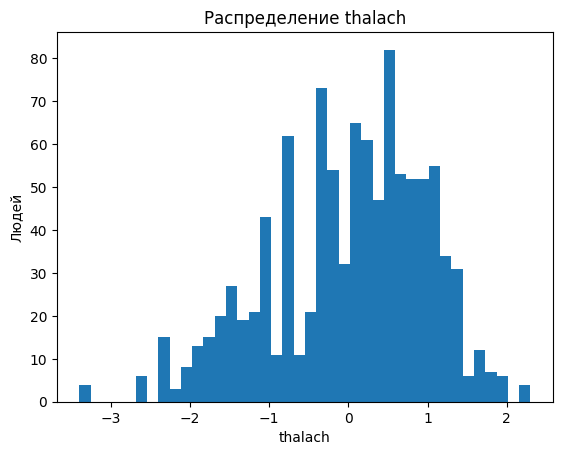

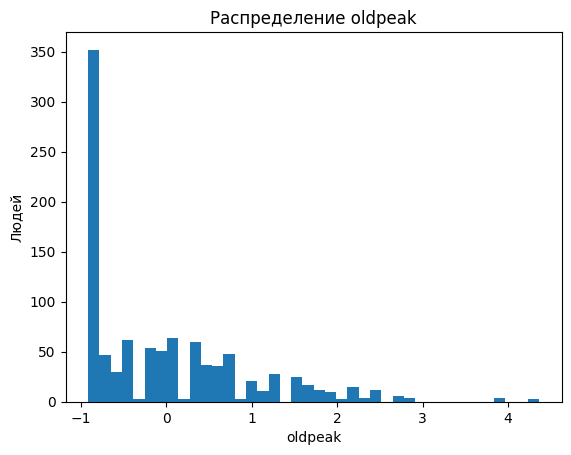

In [20]:
import torch
import numpy
uncategorial_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

X_tensor = torch.tensor(df[uncategorial_cols].values).float()
means = X_tensor.mean(dim=0, keepdim=True)
stds = X_tensor.std(dim=0, keepdim=True)

X_scaled = (X_tensor - means) / stds


for i, col in enumerate(uncategorial_cols):
  data = X_scaled[:, i].numpy()
  plt.xlabel(f'{col}')
  plt.ylabel(f'Людей')
  plt.hist(data, bins=40)

  plt.title(f'Распределение {col}')
  plt.show()



Собираем данные в один dataframe

In [21]:
df_cat_encoded = pd.get_dummies(df[categorial_cols].astype(str), drop_first=True)
X_scaled_df = pd.DataFrame(X_scaled.numpy(), columns=uncategorial_cols)
X_full = pd.concat([X_scaled_df, df_cat_encoded], axis=1)
target_col = ['target']
y = df[target_col].values

X_full = X_full.astype(float)


Создадим модель и датасет

In [22]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
print(X_full.shape[1])
class Model(nn.Module):
    def __init__(self, dropout, neurons_layer1, neurons_layer2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=X_full.shape[1], out_features=neurons_layer1), # [22 → 123]
            nn.ReLU(),
            nn.Dropout(dropout), # 0.22
            nn.Linear(neurons_layer1, neurons_layer2), # [123 → 31]]
            nn.ReLU(),
            nn.Dropout(dropout), # 0.22
            nn.Linear(neurons_layer2, 1), # [31 → 1]
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.model(x)

class HeartDataset(Dataset):
  def __init__(self, data, labels):
    self.data = torch.tensor(data.values).float()
    self.labels = torch.tensor(labels).float()

  def __getitem__(self, index):
    return self.data[index], self.labels[index]

  def __len__(self):
    return len(self.data)


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # Датасет небольшой. Скорость работы быстрее на cpu, чем на gpu/tpu
study = None

22


Воспользуемся подбором гиперпараметров Optuna

In [23]:
OptunaFlag = True if input("Желаете воспользоваться подбором гиперпараметров (да)?").lower() in ("да", "lf", "+", "1") else False
if OptunaFlag:
  !pip install optuna
  import optuna
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
  import time
  from sklearn.model_selection import KFold, StratifiedKFold
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
  from torch.utils.data import Subset, DataLoader, Dataset #subset для выборки части датасета по заданным индексам


  # Определение функции для тренировки и валидации модели
  def objective(trial):
      # Настройка гиперпараметров
      neurons_layer1 = trial.suggest_int('neurons_layer1', 16, 128)  # Количество нейронов в первом слое
      neurons_layer2 = trial.suggest_int('neurons_layer2', 8, 64)    # Количество нейронов во втором слое
      dropout = trial.suggest_uniform('dropout', 0.2, 0.5)           # Dropout от 0.2 до 0.5
      lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)                # Логарифмический выбор learning rate
      batch_size = trial.suggest_categorical('batch_size', [16, 32, 64]) # Категориальный выбор размера выборки
      kfold_splits = trial.suggest_int('kfold_splits', 4, 12)        # Размер делений kfold

      trial_start = time.time()

      # Возвращаем accuracy для Optuna
      result = model_Training(neurons_layer1, neurons_layer2, dropout, lr,
                    batch_size, kfold_splits)
      print(f"\n✅ Trial {trial.number} завершён за {time.time()-trial_start:.2f} сек")

      return result

  def model_Training(neurons_layer1, neurons_layer2, dropout,
                    lr, batch_size, kfold_splits):



      kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
      start_time = time.time()

      val_accs = []
      time_ = []
      total_fold_time = 0  # Для сбора общей статистики

      for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full, y)):
          fold_start = time.time()

          print(f"\n🌀 Fold {fold+1}/{kfold_splits} начат...")

          # Создаем модель с гиперпараметрами из Optuna
          model = Model(dropout, neurons_layer1, neurons_layer2).to(device)

          # Оптимизатор с L2-регуляризацией (weight_decay)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          crit = nn.BCELoss().to(device)


          #make a dataloader
          train_dl = DataLoader(
              HeartDataset(X_full.iloc[train_idx], y[train_idx]),
              batch_size=batch_size,
              shuffle=True,
              pin_memory=True)

          val_dl = DataLoader(
              HeartDataset(X_full.iloc[val_idx], y[val_idx]),
              batch_size=batch_size,
              pin_memory=True)

          # Тренировка
          model.train()
          for epoch in range(10):
              for xb, yb in train_dl:
                  xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                  optimizer.zero_grad()
                  pred = model(xb)
                  loss = crit(pred, yb)
                  loss.backward()
                  optimizer.step()

          # Валидация
          model.eval()
          y_true, y_pred = [], []
          with torch.no_grad():
              for xb, yb in val_dl:
                  xb, yb = xb.to(device), yb.to(device)

                  pred = model(xb)
                  prediction = (pred > 0.5).float()
                  # Переносим результаты на CPU для sklearn
                  y_true.extend(yb.cpu().numpy())
                  y_pred.extend(prediction.cpu().numpy().flatten())

          # Рассчитываем метрики
          acc = accuracy_score(y_true, y_pred)
          # precision = precision_score(y_true, y_pred)
          recall = recall_score(y_true, y_pred)
          # f1 = f1_score(y_true, y_pred)


          # val_accs.append(acc)
          val_recall.append(recall)

          fold_time = time.time() - fold_start
          total_fold_time += fold_time
          print(f"⏱️ Fold {fold+1} завершён за {fold_time:.2f} сек | Recall: {recall:.4f} | Точность: {acc:.4f}")
      return sum(val_recall)/len(val_recall) # average




Желаете воспользоваться подбором гиперпараметров (да)?no


In [24]:
# # Оптимизация гиперпараметров с помощью Optuna
if OptunaFlag:
  time_ = time.time()
  optuna.logging.set_verbosity(optuna.logging.WARNING)
  study = optuna.create_study(direction='maximize')  # Цель - максимизация recall
  study.optimize(objective, n_trials=15, n_jobs=1)
  print(f"Весь optuna выполнен за: {time.time()-time_:.2f}")

  print(f"Best hyperparameters: {study.best_params}")


#Весь optuna выполнен за: 102.79 - gpu
# Весь optuna выполнен за: 78.42 - cpu
# Trial 32 finished with value: 0.974623803009576 and parameters: {'neurons_layer1': 123, 'neurons_layer2': 31, 'dropout': 0.22125162836853784, 'lr': 0.011898235544978132, 'batch_size': 64, 'kfold_splits': 12}. Best is trial 32 with value: 0.974623803009576.


Тренировка модели.

Формируем тестовые и валидационные данные, используя k-fold cross-validation
(Обучение k раз при k равных частях данных)


In [25]:


#Выбираем лучшие параметры, которые смогли подобрать
if study is None: # Уже подобранные параметры, acc = 97%
  neurons_layer1 = 123
  neurons_layer2 = 31
  dropout = 0.22125162836853784
  batch_size = 64
  lr = 0.011898235544978132
  kfold_splits = 12
else:  # Параметры, которые только что добыли при помощи optuna
  neurons_layer1 = study.best_params['neurons_layer1']
  neurons_layer2 = study.best_params['neurons_layer2']
  dropout = study.best_params['dropout']
  batch_size = study.best_params['batch_size']
  lr = study.best_params['lr']
  kfold_splits = study.best_params['kfold_splits']





In [26]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Subset, DataLoader, Dataset #subset для выборки части датасета по заданным индексам
import matplotlib.pyplot as plt
import time
import sys

best_recall = 0 # Обнуляем при каждом запуске этого блока кода
best_f1 = 0
train_loss, train_acc = [], []
val_accs, val_recall, val_loss  = [], [], []
time_ = []
all_metrics = []

kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True) #Сохраняет пропорции классов ('target') в каждом фолде
start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full, y)):
    print(f'📁 Fold {fold + 1}')
    t0 = time.time()



    train_dl = DataLoader(
        HeartDataset(X_full.iloc[train_idx], y[train_idx]),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)

    val_dl = DataLoader(
        HeartDataset(X_full.iloc[val_idx], y[val_idx]),
        batch_size=batch_size,
        pin_memory=True)


    model = Model(dropout, neurons_layer1, neurons_layer2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.BCELoss().to(device)


    #Тренировка
    model.train()
    for epoch in range(10):
      for xb, yb in train_dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        optimizer.step()

    #Валидация модели
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
      for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        prediction = (pred > 0.5).float()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(prediction.cpu().numpy().flatten()) # flatten превращает в вектор

    elapsed = time.time() - t0
    time_.append(elapsed)
    print(f"  Fold {fold + 1} завершён за {elapsed:.2f} сек\n")

    acc = accuracy_score(y_true, y_pred)    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    prec = precision_score(y_true, y_pred)  # Precision = TP / (TP + FP)
    recall = recall_score(y_true, y_pred)   # Recall = TP / (TP + FN)
    f1 = f1_score(y_true, y_pred)           # F1 = 2 * (Precision * Recall) / (Precision + Recall)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    val_accs.append(acc)
    val_recall.append(recall)


    if (best_recall <= recall and best_f1 <= f1):
      best_recall = recall
      # torch.save(model.state_dict(), f'model_state_dict_fold_{fold + 1} (rec: {best_recall:.4f}).pt')
      print(f'Model saved. Fold: {fold + 1}; Recall: {best_recall:.4f}')




📁 Fold 1
  Fold 1 завершён за 8.34 сек

Accuracy: 0.9535, Precision: 0.9167, Recall: 1.0000, F1: 0.9565
Model saved. Fold: 1; Recall: 1.0000
📁 Fold 2
  Fold 2 завершён за 0.31 сек

Accuracy: 0.9651, Precision: 0.9767, Recall: 0.9545, F1: 0.9655
📁 Fold 3
  Fold 3 завершён за 0.28 сек

Accuracy: 0.9767, Precision: 0.9773, Recall: 0.9773, F1: 0.9773
📁 Fold 4
  Fold 4 завершён за 0.29 сек

Accuracy: 0.9651, Precision: 0.9767, Recall: 0.9545, F1: 0.9655
📁 Fold 5
  Fold 5 завершён за 0.30 сек

Accuracy: 0.9651, Precision: 0.9556, Recall: 0.9773, F1: 0.9663
📁 Fold 6
  Fold 6 завершён за 0.30 сек

Accuracy: 0.9647, Precision: 0.9545, Recall: 0.9767, F1: 0.9655
📁 Fold 7
  Fold 7 завершён за 0.29 сек

Accuracy: 0.9647, Precision: 0.9545, Recall: 0.9767, F1: 0.9655
📁 Fold 8
  Fold 8 завершён за 0.29 сек

Accuracy: 0.9882, Precision: 0.9778, Recall: 1.0000, F1: 0.9888
Model saved. Fold: 8; Recall: 1.0000
📁 Fold 9
  Fold 9 завершён за 0.29 сек

Accuracy: 0.9765, Precision: 0.9773, Recall: 0.9773, F

In [27]:
total_time = time.time() - start_time
print(f"\n  Всё обучение завершено за {total_time:.2f} секунд")
print(f"  Среднее время обучения: {sum(time_)/len(time_):.2f} сек")

print(f"Highest validation recall: {max(val_recall):.4f}:")
print(f"Average validation recall: {sum(val_recall)/len(val_recall):.4f}")
print(f"Lowest validation recall: {min(val_recall):.4f}\n" )

print(f"Highest validation accuracy: {max(val_accs):.4f}:")
print(f"Average validation accuracy: {sum(val_accs)/len(val_accs):.4f}")
print(f"Lowest validation accuracy: {min(val_accs):.4f}")


  Всё обучение завершено за 11.71 секунд
  Среднее время обучения: 0.96 сек
Highest validation recall: 1.0000:
Average validation recall: 0.9734
Lowest validation recall: 0.9091

Highest validation accuracy: 1.0000:
Average validation accuracy: 0.9698
Lowest validation accuracy: 0.9412


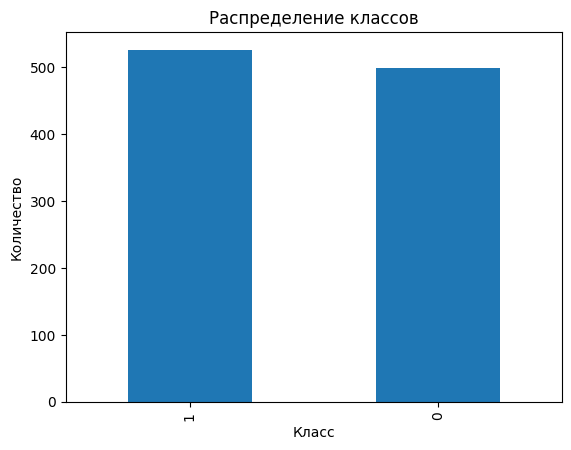

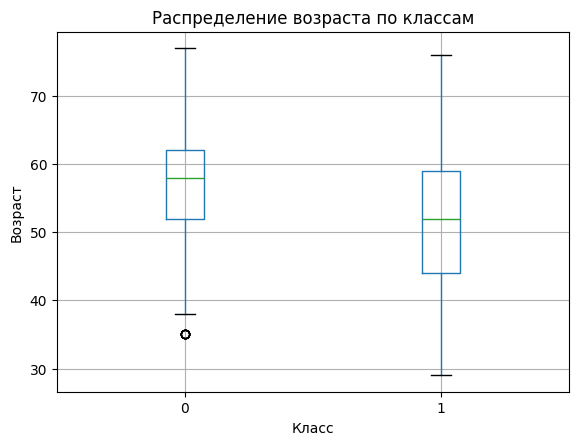

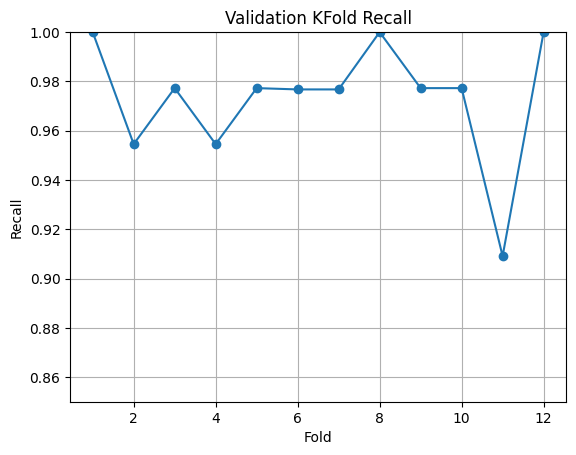

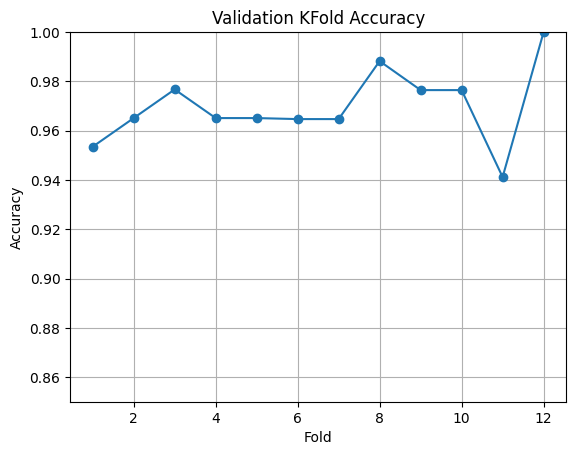

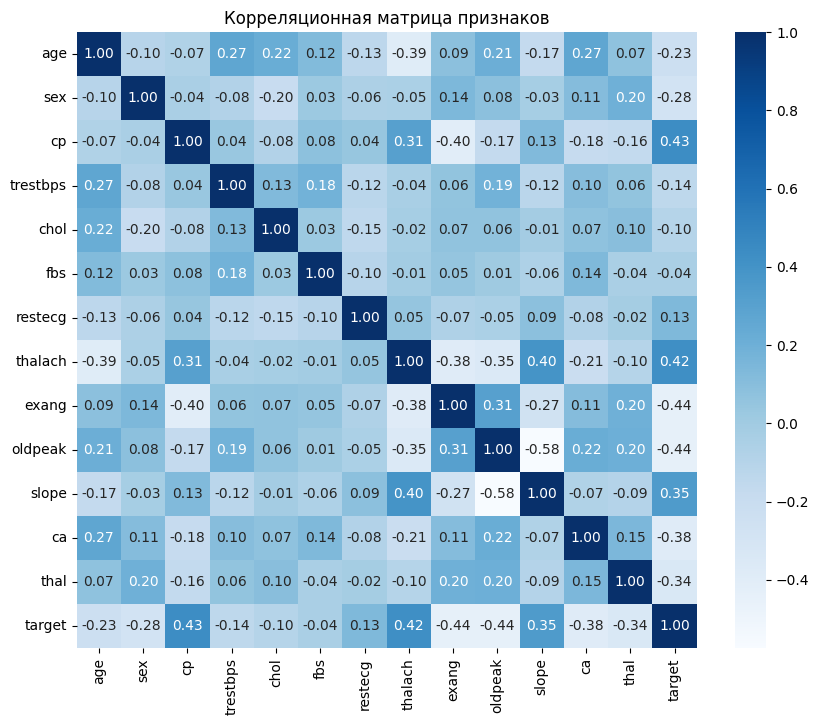

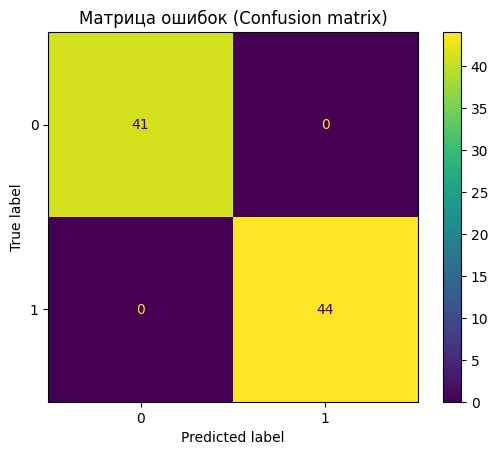

In [28]:
class_counts = df['target'].value_counts()
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()





df.boxplot(column='age', by='target')
plt.title('Распределение возраста по классам')
plt.xlabel('Класс')
plt.ylabel('Возраст')
plt.suptitle('')
plt.show()


plt.plot(range(1, kfold_splits+1), val_recall, marker='o')
plt.title('Validation KFold Recall')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.ylim(0.85, 1.0)
plt.grid(True)
plt.show()

plt.plot(range(1, kfold_splits+1), val_accs, marker='o')
plt.title('Validation KFold Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.grid(True)
plt.show()


import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Корреляционная матрица признаков')
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Матрица ошибок (Confusion matrix)')
plt.show()



